## Colab Implementation

In [ ]:
# latent_dim: int=64

In [1]:
!pip install datasets
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install typer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from typing import *
import torchvision.transforms as transforms
from torch.distributions import Normal

IMAGE_SIZE = 100

decode_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_SIZE)])  # used by decode method to transform final output

class VAE(nn.Module):

    def __init__(self,
                 in_channels,
                 latent_dim,
                 hidden_dims=None,
                 **kwargs):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        out = self.encoder(torch.rand(1, 3, IMAGE_SIZE, IMAGE_SIZE))
        self.size = out.shape[2]
        self.fc_mu = nn.Linear(hidden_dims[-1] * self.size * self.size, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * self.size * self.size, latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.size * self.size)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Sigmoid())

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 512, self.size, self.size)
        result = self.decoder(result)
        result = self.final_layer(result)
        result = decode_transform(result)
        result = torch.nan_to_num(result)
        return result

    def log_likelihood(self, x, n_samples=1000):
        bsize = x.shape[0]
        imsize = np.prod(x.shape[1:])

        with torch.no_grad():
            mu, log_var = self.encode(x)
            log_weights = torch.zeros(bsize, n_samples).cuda()

            for k in range(n_samples):
                z = self.reparameterize(mu, log_var)

                log_qz_x = Normal(mu, torch.sqrt(torch.exp(log_var))).log_prob(z).sum(-1)

                log_pz = Normal(0, 1).log_prob(z).sum(-1)

                decoded = self.decode(z)

                # assume normal distribution since we trained with MSE loss on reconstruction
                log_px_z = -((x.view(bsize, -1) - decoded.view(bsize, -1))**2).sum(-1)

                log_weights[:, k] = log_px_z + log_pz - log_qz_x

        max_log_weights = torch.max(log_weights, dim=1, keepdim=True)[0]
        log_likelihood = (
            max_log_weights.squeeze() +
            torch.log(torch.mean(
                torch.exp(log_weights - max_log_weights), dim=1
            ))
        )

        return log_likelihood


    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs):
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        bsize = input.shape[0]

        kld_weight = kwargs['M_N'] 
        recons_loss = F.mse_loss(recons.view(bsize, -1), input.view(bsize, -1))

       
        kld_loss = -0.5 * torch.mean(1 + log_var - mu ** 2 - log_var.exp())

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss.detach(), 'KLD': -kld_loss.detach()}

    def sample(self,
               num_samples,
               current_device):

        z = torch.randn(num_samples,
                        self.latent_dim)


        z = z.to(current_device)

        log_z = Normal(
            torch.zeros_like(z),
            torch.ones_like(z)
        ).log_prob(z).sum(-1)

        sample_means = self.decode(z)


        return sample_means, log_z

    def generate(self, x, **kwargs):

        return self.forward(x)[0]


## Train VAE

In [ ]:
from datasets import load_dataset
from collections import defaultdict
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ConstantLR, LinearLR, SequentialLR
import os
import pandas

IMAGE_SIZE=100

celeb_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()])  # used when transforming image to tensor

def collator(batch):
    batch = {
        'image': torch.stack([b['image'] for b in batch])
    }
    return batch


nepochs: int=10
bsize: int=8
lr: float=1e-3

os.makedirs(f'vae_ldim_{latent_dim}', exist_ok=True)

# load dataset
data = load_dataset('nielsr/CelebA-faces', split='train')
data = data.train_test_split(test_size=0.00025)

# set transforms
def celeb_t(examples):
    examples['image'] = [celeb_transform(image) for image in examples['image']]
    return examples

data.set_transform(celeb_t) # 100 x 100 x 3

# load model
model = VAE(
    in_channels=3,
    latent_dim=latent_dim, # maybe select them some other way?
)
model.cuda()

batch_per_epoch = int(len(data['train']) / bsize)

loader = DataLoader(data['train'], batch_size=bsize, collate_fn=collator, shuffle=True)
test_loader = DataLoader(data['test'], batch_size=bsize, collate_fn=collator, shuffle=True)

optim = Adam(model.parameters(), lr=lr)
scheduler = SequentialLR(
    optim,
    schedulers=[
        LinearLR(optim, start_factor=1e-3, end_factor=1, total_iters=batch_per_epoch),
        ConstantLR(optim, factor=1, total_iters=(nepochs - 2) * batch_per_epoch),
        LinearLR(optim, start_factor=1, end_factor=1e-3, total_iters=batch_per_epoch),
    ],
    milestones=[batch_per_epoch, (nepochs - 1) * batch_per_epoch],
)
optim.zero_grad()

train
all_train_loss = []
all_test_loss = []

for epoch in range(nepochs):
    epoch_loss = defaultdict(float)
    batch_loss = defaultdict(float)
    model.train()

    for i, batch in tqdm(enumerate(loader), total=batch_per_epoch):
        out = model(batch['image'].cuda())
        out[-1] = torch.clamp_(out[-1], -10, 10)
        loss = model.loss_function(*out, M_N=0.00025)
        loss['loss'].backward()
        optim.step()
        optim.zero_grad()
        scheduler.step()

        for k, l in loss.items():
            epoch_loss[k] += l.item()
            batch_loss[k] += l.item()

        if (i + 1) % 1000 == 0:
            res_str = f"Iter {i+1}/{batch_per_epoch}: ({scheduler.get_last_lr()[0]:.4f})"
            for k, l in batch_loss.items():
                res_str += f" {k}: {l / 1000:.4f}"
            print(res_str, flush=True)
            batch_loss = defaultdict(float)

    print(f"Epoch {epoch + 1}/{nepochs}: loss {epoch_loss['loss'] / batch_per_epoch}")
    all_train_loss.append(epoch_loss['loss'] / batch_per_epoch)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
          out = model(batch['image'].cuda())
          test_loss += model.loss_function(*out, M_N=0.00025)['loss'].item()

    print('====> Test set loss: {:.4f}'.format(test_loss))
    all_test_loss.append(test_loss)

    torch.save(model, f'vae_ldim_{latent_dim}/e{epoch}.pt')

    losses = {
        "train": all_train_loss,
        "test": all_test_loss
    }
    df = pandas.DataFrame(losses)
    df.to_csv(f'vae_ldim_{latent_dim}/losses.csv')

<ipython-input-77-b6e8b309a9d7>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


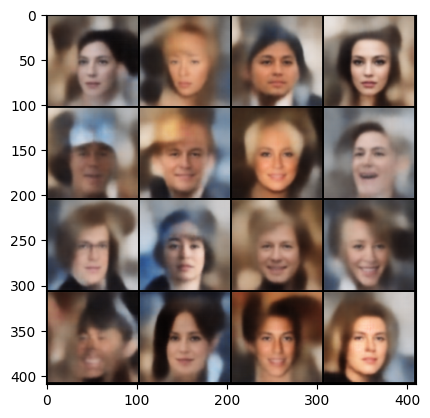

In [ ]:
# # prompt: sample from the model and print the images

# import matplotlib.pyplot as plt
# import torchvision

# # Load the trained model (replace with the actual path to your model)
# model_path = f'vae_ldim_64/e5.pt'  # Assuming you want the last epoch
# model = torch.load(model_path)
# model.eval()

# # Generate samples
# with torch.no_grad():
#     samples, _ = model.sample(16, 'cuda')  # Generate 16 samples

# # Display the images
# grid = torchvision.utils.make_grid(samples, nrow=4)  # Create a grid of images
# plt.imshow(grid.permute(1, 2, 0).cpu())  # Move to CPU and permute dimensions for display
# plt.show()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ld2 vs ld4 already exists, skipping
Running 2 vs 8
cuda


100%|██████████| 10/10 [01:50<00:00, 11.06s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 2 vs 16
cuda


100%|██████████| 10/10 [01:49<00:00, 11.00s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 2 vs 32
cuda


100%|██████████| 10/10 [01:50<00:00, 11.01s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 2 vs 64
cuda


100%|██████████| 10/10 [01:50<00:00, 11.00s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 2 vs 128
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 4 vs 2
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 4 vs 8
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 4 vs 16
cuda


100%|██████████| 10/10 [01:49<00:00, 10.97s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 4 vs 32
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 4 vs 64
cuda


100%|██████████| 10/10 [01:49<00:00, 11.00s/it]


Running 4 vs 128


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


100%|██████████| 10/10 [01:50<00:00, 11.01s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 8 vs 2
cuda


100%|██████████| 10/10 [01:50<00:00, 11.01s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 8 vs 4
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]


Running 8 vs 16


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 8 vs 32
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 8 vs 64
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 8 vs 128
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 16 vs 2
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 16 vs 4
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 16 vs 8
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 16 vs 32
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 16 vs 64
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 16 vs 128
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 32 vs 2
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 32 vs 4
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 32 vs 8
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 32 vs 16
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 32 vs 64
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 32 vs 128
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 64 vs 2
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 64 vs 4
cuda


100%|██████████| 10/10 [01:49<00:00, 11.00s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 64 vs 8
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 64 vs 16
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 64 vs 32
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 64 vs 128
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 128 vs 2
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 128 vs 4
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]


Running 128 vs 8


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 128 vs 16
cuda


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 128 vs 32
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 128 vs 64
cuda


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]


  adding: kl_diffs/ (stored 0%)
  adding: kl_diffs/ld64_vs_ld32/ (stored 0%)
  adding: kl_diffs/ld64_vs_ld32/diff.pt (deflated 19%)
  adding: kl_diffs/ld64_vs_ld32/img.pt (deflated 7%)
  adding: kl_diffs/ld128_vs_ld2/ (stored 0%)
  adding: kl_diffs/ld128_vs_ld2/diff.pt (deflated 20%)
  adding: kl_diffs/ld128_vs_ld2/img.pt (deflated 7%)
  adding: kl_diffs/ld16_vs_ld128/ (stored 0%)
  adding: kl_diffs/ld16_vs_ld128/diff.pt (deflated 19%)
  adding: kl_diffs/ld16_vs_ld128/img.pt (deflated 7%)
  adding: kl_diffs/ld32_vs_ld2/ (stored 0%)
  adding: kl_diffs/ld32_vs_ld2/diff.pt (deflated 20%)
  adding: kl_diffs/ld32_vs_ld2/img.pt (deflated 7%)
  adding: kl_diffs/ld2_vs_ld16/ (stored 0%)
  adding: kl_diffs/ld2_vs_ld16/diff.pt (deflated 20%)
  adding: kl_diffs/ld2_vs_ld16/img.pt (deflated 7%)
  adding: kl_diffs/ld16_vs_ld32/ (stored 0%)
  adding: kl_diffs/ld16_vs_ld32/diff.pt (deflated 20%)
  adding: kl_diffs/ld16_vs_ld32/img.pt (deflated 7%)
  adding: kl_diffs/ld4_vs_ld64/ (stored 0%)
  adding: